# Political Bias Detection in German News Articles

In [1]:
import tensorflow
from explore_data import*
from prepare_data import*
from classifiers.embedding import*
from classifiers.lstm import*
from classifiers.cnn import*
%load_ext autoreload
%autoreload 2

/opt/anaconda/envs/playground/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda/envs/playground/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda/envs/playground/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda/envs/playground/lib/python

## Data Exploration

### GermaParl

In order to explore GermaParl download the dataset from [here](https://github.com/PolMine/GermaParlTEI).

In [2]:
germa_parl = GermaParl('GermaParlTEI')

### News Articles

Either download the the pickle files from [here](https://drive.google.com/file/d/13Kp7rEwMcM-1wb8usEjdnxbLGZPO3y2f/view?usp=sharing) or run ScrapeArchive.jf for scraping the archive of junge freiheit and so on. 

#### Junge Freiheit

In [3]:
jf = Archive('NewsArchive/jungefreiheit_archive.pkl')

#### Jungle World

In [4]:
jw = Archive('NewsArchive/jungleworld_archive.pkl')

#### Sueddeutsche Zeitung

In [5]:
sz = Archive('NewsArchive/sueddeutsche_archive.pkl')

### Bringing everything together

In [6]:
data = germa_parl.texts + jf.texts + jw.texts + sz.texts
labels = germa_parl.labels + jf.labels + jw.labels + sz.labels

In [7]:
len(data)

444549

In [8]:
num_words_per_sample(data)

277.0

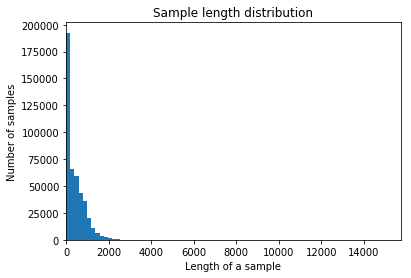

In [9]:
plot_sample_length_distribution(data)

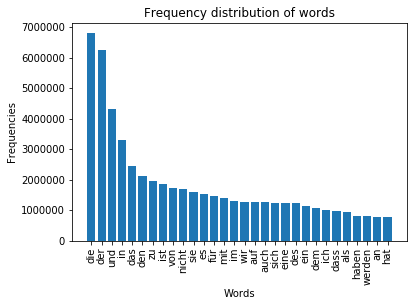

In [10]:
data_word_frequency = plot_word_frequency_distribution(data)

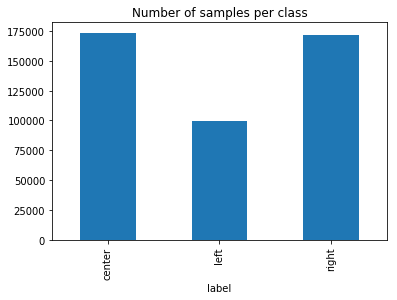

In [11]:
plot_num_samples_per_class(labels)

## Data Preperation

Calculate the number of samples/number of words per sample ratio.

In [12]:
len(data)/num_words_per_sample(data)

1604.870036101083

Ratio is greater than 1500, we tokenize the text as sequences and use a pretrained fine-tuned pre-trained embedding. For this, download the vocabulary and vectors from [here](https://deepset.ai/german-word-embeddings) and place it in GloVe folder.

In [13]:
sequence_vectorize = SequenceVectorize(data, vocab=False)
vect_texts = sequence_vectorize.vectorize()

In [14]:
train_texts, train_labels, val_texts, val_labels, test_texts, test_labels = train_val_test_split(vect_texts, 
                                                                                                 labels, 
                                                                                                 reproduceable=True)

In [15]:
val_labels[3]

array([0., 0., 1.])

In [16]:
_, label_encoder = onehot_encoding(labels)

In [17]:
onehot_decoding(val_labels[3], label_encoder)

array(['right'], dtype='<U6')

## Model Building

In [18]:
embedding_layer = get_embedding(sequence_vectorize.word_index, train_texts.shape[1], pretrained_embedding=True)

In [ ]:
lstm = LongShortTermMemory(embedding_layer, train_labels.shape[1])
opt = tensorflow.keras.optimizers.Adam(learning_rate=1e-3)
model = lstm.stacked_lstm(opt, out_dim=32, dropout=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          6000300   
_________________________________________________________________
lstm (LSTM)                  (None, 500, 512)          1665024   
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 256)          787456    
_________________________________________________________________
lstm_2 (LSTM)                (None, 500, 128)          197120    
_________________________________________________________________
lstm_3 (LSTM)                (None, 500, 64)           49408     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 3)                 9

## Training

In [ ]:
my_callbacks = [
    tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
    tensorflow.keras.callbacks.ModelCheckpoint(filepath='models/lstm.{epoch:02d}-{val_loss:.2f}.h5'),
    tensorflow.keras.callbacks.TensorBoard(log_dir='models/./logs'),
]

class_weight = compute_class_weight(labels)

In [ ]:
model.fit(train_texts, train_labels, validation_data=(val_texts, val_labels), 
          epochs=1000, batch_size=512, verbose=1, callbacks=my_callbacks, class_weight=class_weight)

Epoch 1/1000
695/695 [==============================] - 476s 685ms/step - loss: 1.2784 - accuracy: 0.3712 - val_loss: 1.0954 - val_accuracy: 0.3852
Epoch 2/1000
695/695 [==============================] - 474s 682ms/step - loss: 1.2859 - accuracy: 0.3400 - val_loss: 1.0671 - val_accuracy: 0.4498
Epoch 3/1000
695/695 [==============================] - 474s 682ms/step - loss: 1.2828 - accuracy: 0.3514 - val_loss: 1.0954 - val_accuracy: 0.3852
Epoch 4/1000
695/695 [==============================] - 473s 681ms/step - loss: 1.2879 - accuracy: 0.3334 - val_loss: 1.1038 - val_accuracy: 0.2263
Epoch 5/1000
695/695 [==============================] - 473s 681ms/step - loss: 1.2879 - accuracy: 0.3286 - val_loss: 1.0981 - val_accuracy: 0.3852
Epoch 6/1000
695/695 [==============================] - 473s 681ms/step - loss: 1.2801 - accuracy: 0.3464 - val_loss: 1.0512 - val_accuracy: 0.3711
Epoch 7/1000
695/695 [==============================] - 474s 682ms/step - loss: 1.1993 - accuracy: 0.4374 - val_